#Transfer Learning
Transfer learning is a machine learning technique where a model developed for a particular task is reused as the starting point for a model on a second task. It's especially useful in deep learning, where substantial amounts of data and computational power are typically required to train models from scratch. Transfer learning leverages the knowledge a model has learned from a previously related task to improve learning efficiency and prediction accuracy for a new, but related, problem. This approach can significantly reduce the time and resources needed for model training, making advanced machine learning capabilities more accessible and practical for a wider range of applications.


In this notebook, we apply Transfer Learning to the task of Image Classification, specifically focusing on the classification of various types of flowers.

## Importing the required packages

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import cv2
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import make_grid


In this notebook, we define the following constants. It is a good practice to introduce your constants early in the notebook, for a higher visibility, using all capital letters for their names.

In [2]:
MEAN = (0.485, 0.456, 0.406) # first one is mean of red, next is mean of green, next is mean of blue b/c image is 3 matrices
STD = (0.229, 0.224, 0.225)
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 32
NUM_EPOCHS = 10 # how many cycles you train model
BEST_MODEL_PATH = 'best_model.pt'

#Image Augmentation

**Image augmentation** is a powerful technique that helps to increase the diversity of your training data by applying random (but realistic) transformations such as rotation, shearing, zooming, etc. This method can artificially expand the size of the dataset, thereby improving ability of a model to better generalize to unseen data.

In this context, we utilize the [**Albumentations**](https://github.com/albumentations-team/albumentations) package for our image augmentation needs. Albumentations is an image augmentation library that provides a wide variety of augmentation techniques with the aim of achieving more robust and accurate models. By using Albumentations, we can effectively increase the variability of our data, enhancing the performance of our model.

In [3]:
class AlbumentationsTransform:
  """A class to make Albumentations compatible with built-in torchvision Datasets.

  This class takes an Albumentations transformation as input and makes it
  behaive astorchvision Transform objects. Note that if you are using your own
  dataset, this is not needed.

  Attributes:
    transform: An Albumentations transform object.

    """
  def __init__(self, transform):
    """Initializes AlbumentationsTransform with a given PyTorch transform.

    Args:
      transform: An Albumentations transform object.
    """
    self.transform = transform

  def __call__(self, img):
    img = np.array(img)
    augmented = self.transform(image=img)
    img = augmented['image']
    return img

## Augmentation Pipelines

In [4]:
train_transform = A.Compose(
    transforms=[
        A.Flip(p=0.5),
        A.Rotate(
            limit=(-15, 15),
            interpolation=1,
            border_mode=0,
            value=0,
            mask_value=0,
            always_apply=False,
            p=0.5,
        ),
        A.ColorJitter(
            brightness=0.3,
            contrast=0.5,
            saturation=0.5,
            hue=0.2,
            always_apply=False,
            p=0.5,
        ),
        A.ChannelShuffle(p=0.2),
        A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
        A.HueSaturationValue(
            hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5
        ),
        A.ToGray(p=0.2),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.2),
        A.GaussianBlur(blur_limit=(3, 7), p=0.1),
        A.MotionBlur(blur_limit=(3, 7), p=0.1),
        A.GaussNoise(var_limit=(10.0, 50.0), mean=50, p=0.1),
        A.Resize(height=HEIGHT, width=WIDTH, always_apply=True),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ],
    p=1.0,
)
train_transform = AlbumentationsTransform(train_transform)


valid_test_transform = A.Compose(
    transforms=[
        A.Resize(height=HEIGHT, width=WIDTH, always_apply=True),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ],
    p=1.0,
)
valid_test_transform = AlbumentationsTransform(valid_test_transform)

We use **_Flowers102_** Dataset from *torchvision.datasets*. If you are using your own dataset, you can define your [custom Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) object.

 You can also use
[ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) from **_torchvision.datasets_** to easily build a PyTorch Dataset in one line of code.

In [5]:
train_dataset = datasets.Flowers102('data', split = 'train', download=True,
                                    transform=train_transform)

valid_dataset = datasets.Flowers102('data', split = 'val', download=True,
                                    transform=valid_test_transform)

test_dataset = datasets.Flowers102('data', split = 'test', download=True,
                                   transform=valid_test_transform)


100%|██████████| 344862509/344862509 [00:16<00:00, 20951921.78it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 487168.12it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13410499.71it/s]


## **Always visualize your data**
Data visualization helps to identify issues in data. Remember, the model learns the patterns in your data. If there is a systematic error in your dataset, it can affect the performance of the developed model and its generalizability when applied to unseen data.

In [6]:
def visualize_image_grid(image_label_pairs, rows, cols, mean=MEAN, std=STD):
  """
  Visualizes a grid of images with their labels.

  Args:
    image_label_pairs: A list of tuples, where each tuple is (image, label).
    rows: The number of rows where images are shown.
    cols: The number of columns where images are shown.
  """
  if len(image_label_pairs) != rows * cols:
    raise ValueError("The number of image-label pairs must exactly match rows * cols")
  fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
  for ax, (image, label) in zip(axes.flatten(), image_label_pairs):
    image = image.permute(1, 2, 0)
    image *= torch.Tensor(std)
    image += torch.Tensor(mean)
    ax.imshow(image)
    ax.set_title(f"class {label}")
    ax.axis('off')
  plt.tight_layout()
  plt.show()



Visualizing a subset of images from the training dataset; please note that these images have undergone **`train_transform`**: transformation.

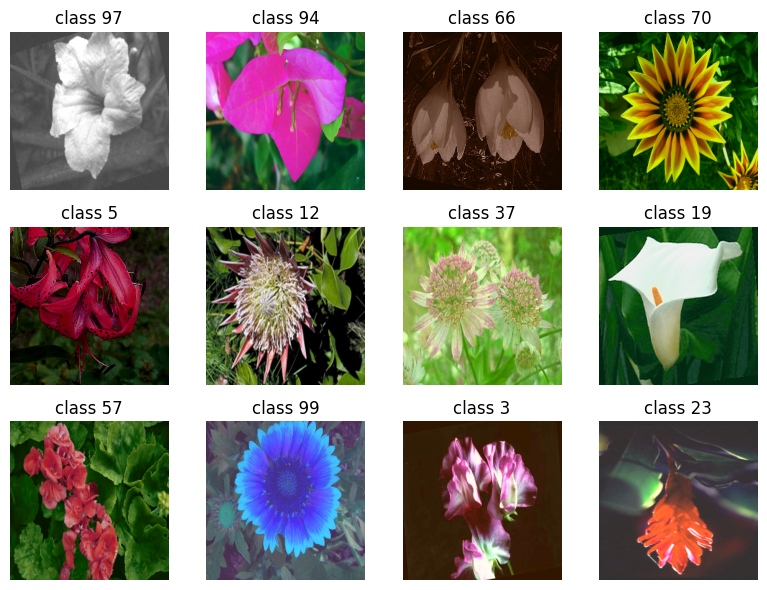

In [7]:
rows = 3
columns = 4
data = train_dataset
indices = np.random.randint(low=0, high=len(data), size=rows*columns)
train_examples = [data[i] for i in indices]
visualize_image_grid(train_examples, rows, columns)

Visualizing a subset of images from the validation dataset; please note that these images have undergone **`valid_test_transform`**: transformation.

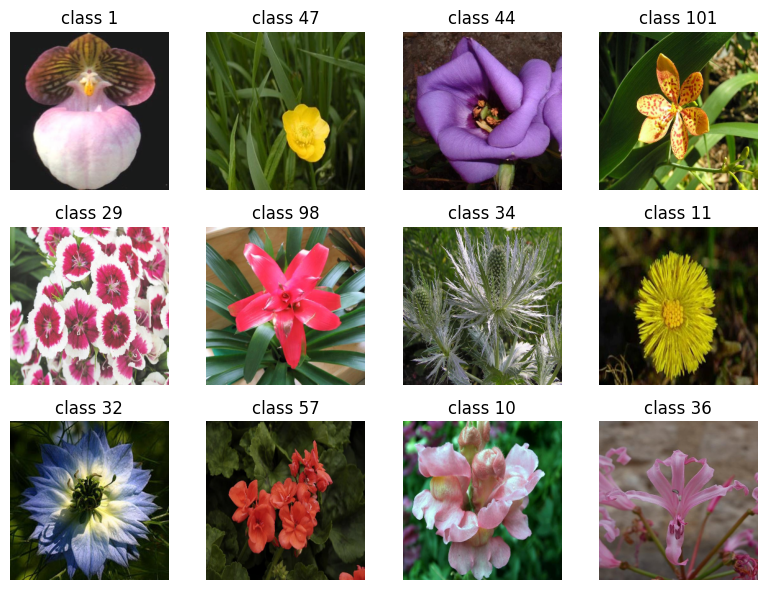

In [8]:
rows = 3
columns = 4
data = valid_dataset
indices = np.random.randint(low=0, high=len(data), size=rows*columns)
train_examples = [data[i] for i in indices]
visualize_image_grid(train_examples, rows, columns)

Visualizing a subset of images from the test dataset; please note that these images have undergone **`valid_test_transform`** transformation.

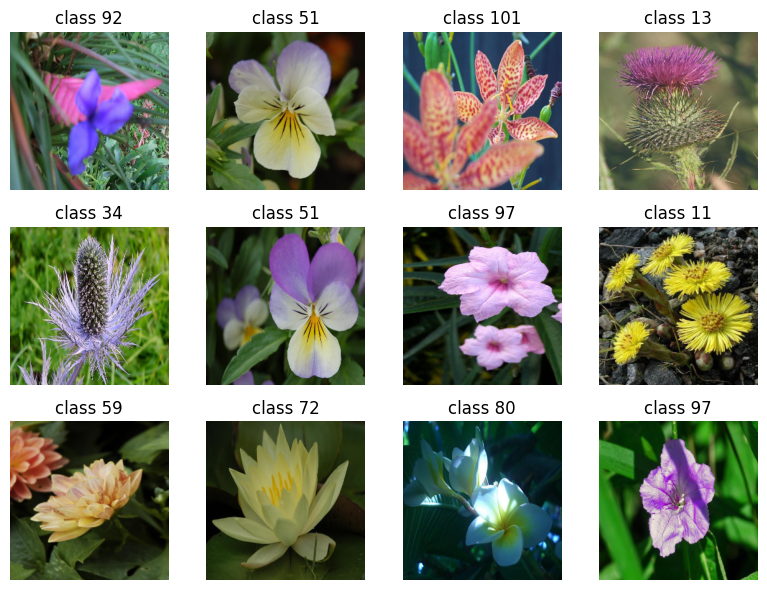

In [9]:
rows = 3
columns = 4
data = valid_dataset
indices = np.random.randint(low=0, high=len(data), size=rows*columns)
train_examples = [data[i] for i in indices]
visualize_image_grid(train_examples, rows, columns)

## Utilizing a model pretrained on ImageNet dataset

Here we use a **`ResNet50`** model from **`torchvision.models`**. torchvision offeres a large number of [common model architecture](https://pytorch.org/vision/stable/models.html) for you to use.

You hae the option to only change the classifier and keep the backbone of the model frozen, i.e. unchanged, or fine-tune the whole model.

In [10]:
def freeze(model):
  for param in model.parameters():
    param.requires_grad = False

# unfreeze the parameters of the first layer
def unfreeze(model):
  for param in model.layer1.parameters():
    param.requires_grad = True

In [11]:
model = models.resnet50(weights='IMAGENET1K_V2')
freeze(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


You can print a model to see detailed information about its architecture.

In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The models trained on **`ImageNet`** encompass 1000 classes. In contrast, the `Flower102` dataset contains 102 classes. As a result, we need to override the classifier component of the **`ResNet50`** model.

In [13]:
classifier = nn.Sequential(
    nn.Linear(in_features=2048, out_features=102)
    )
model.fc = classifier

## Define `DataLoader` objects for training, validation and test datasets
`DataLoader` is a powerful utility that offers seamless iteration over datasets. It abstracts the complexity of data loading, making it easier to work with large datasets that may not fit entirely in memory.

The `DataLoader` supports automatic batching of data. It also provides flexibility for customizing data loading order and loading data in parallel using multiprocessing.

In [14]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

#Selecting the device for model training and evaluation
You can traing and test your model on **CPU** or **GPU**. The latter is much faster and if available should be the choice for model training.

The following line of code defines the device to be GPU if it is available and CPU otherwise:

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
```

**Note:** Google Colab offers a T4 GPU for free. Make sure to activate it under *Edit/Notebook settings* from the colab menu. You can also purchase the V100 and A100 resources, which are computationally stronger and faster.
**Please note that both are subject to monthly and usage caps.**

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
model = model.to(device)


## Loss function

We set up the loss function for model training to be **Cross Entropy Loss**, which is commonly used for classification tasks. It measures the performance of a classification model whose output is a probability value between 0 and 1.

In [16]:
criterion = nn.CrossEntropyLoss()


## Optimization algorithm
We use the **Stochastic Gradient Descent (SGD)** as the optimization algorithm for the model. The `model.parameters()` function provides the model’s parameters to the optimizer. The learning rate (`lr`) is set to 0.01, and the `momentum` is set to 0.9.

The learning rate controls how much to change the model in response to the estimated error each time the model weights are updated.
The momentum can help the model to converge faster and avoid local minima.

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Model evaluation

In [18]:
def evaluation(model, loader, criterion, device, phase='Valid'):
  """Evaluate the performance of a model on a given dataset.

  This function calculates the loss and accuracy of the model on the dataset.
    It also returns the ground truth labels and the model's predictions.

  Args:
    model (torch.nn.Module): The model to be evaluated.
    loader (torch.utils.data.DataLoader): The data loader for the dataset.
    criterion (torch.nn.modules.loss._Loss): The loss function.
    device (torch.device): The device (CPU or GPU) where computations will be performed.
    phase (str, optional): The phase of evaluation. Defaults to 'Valid'.

  Returns:
    dict: A dictionary containing the following keys:
      'loss' (float): The average loss of the model on the dataset.
      'accuracy' (float): The accuracy of the model on the dataset.
      'ground_truth' (list): The ground truth labels of the dataset.
      'predictions' (list): The model's predictions on the dataset.
    """
  model.eval()
  predictions = []
  ground_truth = []
  with torch.no_grad():
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, labels) in enumerate(loader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds.cpu().numpy())
      ground_truth.extend(labels.cpu().numpy())
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f'     {phase} Accuracy={accuracy:<10.4f}  Loss= {loss:<10.4f}')
    return {'loss': loss,
            'accuracy': accuracy,
            'ground_truth': ground_truth,
            'predictions': predictions}

## Model training

In [19]:
def training(model, train_loader, valid_loader, criterion, optimizer, device,
             epochs, best_model_path):
  """Train a model and evaluate its performance on a validation set.

  This function trains a model for a specified number of epochs and evaluates
    its performance on a validation set after each epoch. The model with the
    lowest validation loss is saved.

  Args:
    model (torch.nn.Module): The model to be trained.
    train_loader (torch.utils.data.DataLoader): The data loader for the training set.
    valid_loader (torch.utils.data.DataLoader): The data loader for the validation set.
    criterion (torch.nn.modules.loss._Loss): The loss function.
    optimizer (torch.optim.Optimizer): The optimization algorithm.
    device (torch.device): The device (CPU or GPU) where computations will be performed.
    epochs (int): The number of times the learning algorithm will work through the entire training dataset.
    best_model_path (str): The path where the best model will be saved.

  Returns:
    dict: A dictionary containing the 'loss', 'accuracy', 'ground_truth', and 'predictions'
            of the model with the lowest validation loss.
    """
  model.train()
  best_loss = torch.inf
  best_restults = None
  for epoch in range(epochs):
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      optimizer.zero_grad()
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f'{epoch:<4} Train Accuracy={accuracy:<10.4f}  Loss= {loss:<10.4f}')
    results = evaluation(model, valid_loader, criterion, device)
    if results['loss'] < best_loss:
      torch.save(model, best_model_path)
      best_loss = results['loss']
      best_restults = results
    print()
  return best_restults

## Training the model

In [20]:
best_restults = training(model, train_loader, valid_loader, criterion,
                         optimizer, device, NUM_EPOCHS, BEST_MODEL_PATH)

0    Train Accuracy=0.0373      Loss= 4.5795    
     Valid Accuracy=0.2353      Loss= 4.4305    

1    Train Accuracy=0.2882      Loss= 4.3042    
     Valid Accuracy=0.4725      Loss= 4.1631    

2    Train Accuracy=0.5402      Loss= 3.9983    
     Valid Accuracy=0.5843      Loss= 3.9042    

3    Train Accuracy=0.6392      Loss= 3.7124    
     Valid Accuracy=0.6471      Loss= 3.6583    

4    Train Accuracy=0.6931      Loss= 3.4542    
     Valid Accuracy=0.6824      Loss= 3.4338    

5    Train Accuracy=0.7108      Loss= 3.2207    
     Valid Accuracy=0.7039      Loss= 3.2312    

6    Train Accuracy=0.7686      Loss= 2.9836    
     Valid Accuracy=0.7020      Loss= 3.0445    

7    Train Accuracy=0.7853      Loss= 2.8011    
     Valid Accuracy=0.7265      Loss= 2.8769    

8    Train Accuracy=0.8088      Loss= 2.6097    
     Valid Accuracy=0.7490      Loss= 2.7253    

9    Train Accuracy=0.8176      Loss= 2.4245    
     Valid Accuracy=0.7676      Loss= 2.5855    



## Evaluation of the best model on the test set

In [21]:
best_model = torch.load(BEST_MODEL_PATH)
results = evaluation(best_model, test_loader, criterion, device, 'Test')

     Test Accuracy=0.7439      Loss= 2.6867    
